In [1]:
# declaring all dependancies    
import qutip as qt
import numpy as np
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
from quantum_logical.pulsesim.build_hamiltonian import Build_hamiltonian
import matplotlib.pyplot as plt
from qutip import Options
from tqdm import tqdm_notebook as tqdm
from progressbar import progressbar

opts = Options(nsteps=1e5, atol=1e-8, rtol=1e-6, progress_bar="enhanced")

c:\Users\girgi\Desktop\Github\quantum_logical\venv\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [254]:
# adding all of the necessary elements to the full creation of the system 
qubit_dim = 2

# frequencies 
w1_un = 4
w2_un = 6
w3_un = 4.6666666666666666
ws_un = 5.6666666666666666

# coupling strength coefficient 
g1s = 2 * np.pi * 0.05467
g2s = 2 * np.pi * 0.0435
g3s = 2 * np.pi * 0.04875

# create array of the coefficients should be useful 
gs = [g1s, g2s, g3s]

# unknown value as of now 
g3 = .1

In [255]:
# creating the qubits and the hilbert space
qubit1 = QubitMode(
    mode_type="Qubit", name="q1", dim=2, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    mode_type="Qubit", name="q2", dim=2, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    mode_type="Qubit", name="q3", dim=2, freq=w3_un, alpha=-0.160, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(mode_type="Snail", name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    frozenset([qubit3, snail]): 2 * np.pi * 0.04875
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

system = []
system.extend(qubits)
system.extend([snail])


In [256]:
# list of qubit coupling strengths that will be given
g13 = g23 = g12 = .01
gqs = [[qubit1.freq / (2 * np.pi),g12,g13],[g12,qubit2.freq / (2 * np.pi),g23],[g13,g23,qubit3.freq / (2 * np.pi)]]

# creating the list of alphas that will be given to us 
a1 = a2 = a3 = .001
alphas = [a1, a2, a3]

In [257]:
# building the hammiltonian up to the pump term 
# creating the linear parts of the hamiltonian  
# the qubit and snail separate terms
H_no_interaction = [(i.freq / (2 * np.pi)) * (qs.modes_a_dag[i] * qs.modes_a[i]) for i in system]

# creating the snail mixing with the qubits terms
H_snail_qubits = [gs[qubits.index(i)] * (qs.modes_a[snail] * qs.modes_a_dag[i] + qs.modes_a_dag[snail] * qs.modes_a[i]) for i in qubits]

# adding the coupling terms between the qubits 
H_qubit_qubit = []

for i in range(len(qubits)):
    for j in range(len(qubits)):
        if j > i:
            H_qubit_qubit.append(gqs[i][j] * (qs.modes_a[qubits[i]] * qs.modes_a_dag[qubits[j]] + qs.modes_a_dag[qubits[i]] * qs.modes_a[qubits[j]]))

# creating the nonlinear parts of the hamiltonian 
# adding the snail third order term first 
H_snail_third = [g3 * ((qs.modes_a_dag[snail] + qs.modes_a[snail]) ** 3)]

# add the qubit non-linearity 
H_qubit_fourth = [alphas[qubits.index(i)] * ((qs.modes_a[i] + qs.modes_a_dag[i]) ** 4) for i in qubits]


In [258]:
# creating the non-linear parts of the hamiltonian 

H_total_no_time = []
# adding the linear parts into the hamiltonian 
H_total_no_time.extend(H_no_interaction)
H_total_no_time.extend(H_snail_qubits)
H_total_no_time.extend(H_qubit_qubit)
# adding the non-linear parts 
H_total_no_time.extend(H_snail_third)
H_total_no_time.extend(H_qubit_fourth)


In [259]:
H_no_time = sum(H_total_no_time)

In [309]:
# adding the time dependent terms 
# this might have to be done with a constant pulse first but it should be easy to implement the more complex ones 

H_time = (qs.modes_a[snail] + qs.modes_a_dag[snail])

# making a pulse for the function 
def w_t(a, b, t):
    # return a * np.sin(b * t)
    return a * b

amp = 7
freq = np.abs(qubit1.freq - qubit3.freq) / (2 * np.pi)
def wt(t, args = None):
    return w_t(amp, freq, t)

H = [H_no_time,[H_time, wt]]



In [310]:
# create the intial state 
psi0 = qt.tensor(qt.basis(qubit_dim,1), qt.basis(qubit_dim,0), qt.basis(qubit_dim,0), qt.basis(snail.dim))
# have to find the eigenstates of the hamiltonian in order to find the most fitting starting state
rho0 = psi0 * psi0.dag()

In [311]:
# finding the eigenstates of the hamiltonian before the pulse acts on it and that is the prepared state 
eigenvalues, eigenvectors = H_no_time.eigenstates()

a = []
for i in eigenvectors:
    a.append(np.abs(psi0.dag() * i))

max(a)

# this is now my initial state that is based on the eigenstates of the hamiltonian 
psi0 = eigenvectors[a.index(max(a))]  



In [312]:
# run mesolve over the hamiltonian 
tlist = np.linspace(0,960,200)
result = qt.mesolve(H = H, rho0 = psi0, tlist = tlist, options= opts)

 Total run time:   1.47s*] Elapsed 1.47s / Remaining 00:00:00:00


In [313]:
# before comparing put the states in the eigenstate of the hamiltonian 
# this does not make any sense at all 
for j in range(len(result.states)):
    a = []
    for i in range(len(eigenvectors)):
        a.append(np.abs(result.states[j].dag() * eigenvectors[i]))

    result.states[j] = result.states[a.index(max(a))]


C:\Users\girgi\AppData\Local\Temp\ipykernel_19432\1571096429.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


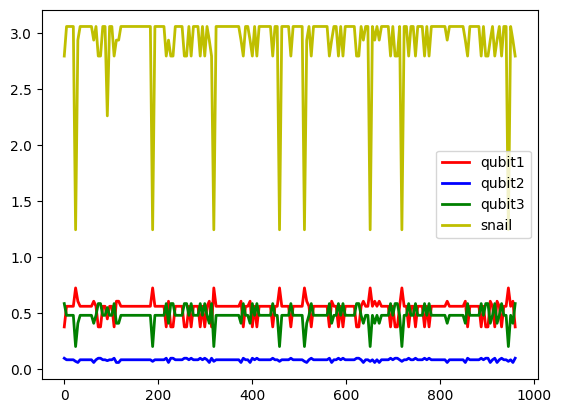

In [314]:
fig, ax = plt.subplots()
ax.plot(tlist, np.abs(qt.expect(qs.modes_a_dag[qubit1]*qs.modes_a[qubit1], result.states)), 'r', linewidth = 2, label = "qubit1")
ax.plot(tlist, np.abs(qt.expect(qs.modes_a_dag[qubit2]*qs.modes_a[qubit2], result.states)), 'b', linewidth = 2, label = "qubit2")
ax.plot(tlist, np.abs(qt.expect(qs.modes_a_dag[qubit3]*qs.modes_a[qubit3], result.states)), 'g', linewidth = 2, label = "qubit3")
ax.plot(tlist, np.abs(qt.expect(qs.modes_a_dag[snail]*qs.modes_a[snail], result.states)), 'y', linewidth = 2, label = "snail")
ax.legend()
fig.show()

In [315]:
num = []
for i in result.states:
    num.append(np.abs(qt.expect(qs.modes_a_dag[qubit1]*qs.modes_a[qubit1], i)) + np.abs(qt.expect(qs.modes_a_dag[qubit2]*qs.modes_a[qubit2], i)) 
    + np.abs(qt.expect(qs.modes_a_dag[qubit3]*qs.modes_a[qubit3], i)))

num

[1.063888464891678,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.0003087076525299,
 1.079225975709171,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.079225975709171,
 1.1293047128193614,
 1.063888464891678,
 1.063888464891678,
 1.1293047128193614,
 1.1293047128193614,
 1.07763037434912,
 1.1293047128193614,
 1.1293047128193614,
 1.063888464891678,
 1.079225975709171,
 1.079225975709171,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.0003087076525299,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.1293047128193614,
 1.063888464891678,
 1.079225975709171,
 1.063888464891678,
 1.06

In [316]:
# creating the expected final state 
psif = qt.tensor(qt.basis(qubit_dim,0), qt.basis(qubit_dim,0), qt.basis(qubit_dim,1), qt.basis(snail.dim))
rhof = psif * psif.dag()

# tracing out the bad parts since the snail may still be excited 
psif = qt.ptrace(psif,[0,1,2])

In [317]:
final_state = qt.ptrace(result.states[-1], [0,1,2])
qt.fidelity(psif, final_state)

0.5518523944400107

In [14]:
# will optimize over the amplitude of the pulse and maybe frequency 
# creating the tuple of amps and frequencies 
amps = np.linspace(0, 8, 10)
freqs = np.linspace(0, 8, 10)
amps_freqs = [(i,j) for i in amps for j in freqs]

def sim_task(amps_freqs):
    amp, freq = amps_freqs

    def w_t(amp, freq, t):
        return amp * np.sin(freq * t)

    def wt(t, args = None):
        return w_t(amp, freq, t)
    
    H_pump = [H_time, wt]

    H_t = [H_no_time, H_pump]

    res = qt.mesolve(H = H_t, rho0 = rho0, tlist = tlist, options= opts)

    # add the fid calculation
    fid = qt.fidelity(res.states[-1], psif)

    return fid


results = qt.parallel.parallel_map(task = sim_task, values = amps_freqs, progress_bar= True)


10.0%. Run time:   0.50s. Est. time left: 00:00:00:04
20.0%. Run time:   0.50s. Est. time left: 00:00:00:02
30.0%. Run time:   0.50s. Est. time left: 00:00:00:01
Total run time:   0.51s


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.